In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from fastai.imports import *
from fastai.dataset import *
from fastai.conv_learner import *
# from pathlib import Path
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [2]:
PATH = Path("data")
list(PATH.iterdir())

[PosixPath('data/list_eval_partition.txt'),
 PosixPath('data/list_attr_cloth.txt'),
 PosixPath('data/img.zip'),
 PosixPath('data/list_attr_img.txt'),
 PosixPath('data/img'),
 PosixPath('data/tmp'),
 PosixPath('data/list_category_cloth.txt'),
 PosixPath('data/list_category_img.txt'),
 PosixPath('data/list_landmarks.txt'),
 PosixPath('data/models'),
 PosixPath('data/list_bbox.txt')]

In [3]:
def extr_data_txt(path):
    with open(path, "r") as f:
        data = []
        for itr, line in enumerate(f):
            if itr >= 2:
                data.append(line.split())
    return data

In [4]:
idx2cat = dict((i, cat[0]) for i, cat in enumerate(extr_data_txt(PATH/'list_category_cloth.txt')))
cat2idx = dict((v,k) for k,v in idx2cat.items())
idx2cat[2], cat2idx["Blouse"]

('Blouse', 2)

In [5]:
train_test_valid_anot = pd.DataFrame(extr_data_txt(PATH/'list_eval_partition.txt'),columns=['Path', 'type'])
# train_test_valid_anot.to_csv(PATH/'train_test_valid_anot.csv' ,index=False)
train_test_valid_anot.head()

,Path,type
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,train
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,train
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,val
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,train
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,test


In [6]:
fileName2cat = pd.DataFrame(extr_data_txt(PATH/'list_category_img.txt'), columns=['Path', 'cat'])
fileName2cat['cat'] = fileName2cat['cat'].apply(lambda x: int(x)-1) # Categories start with 1, fixing it.
# filename2cat.to_csv(PATH/'filename2cat.csv' ,index=False)
fileName2cat.head()

,Path,cat
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,2
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,2
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,2
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,2
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,2


In [7]:
fileName2bbox = pd.DataFrame(extr_data_txt(PATH/'list_bbox.txt'), columns=['Path', 'x1', 'y1', 'x2', 'y2'])
# bbox_img.to_csv(PATH/'bbox_img.csv' ,index=False)
fileName2bbox["x1"] = pd.to_numeric(fileName2bbox["x1"])
fileName2bbox["y1"] = pd.to_numeric(fileName2bbox["y1"])
fileName2bbox["x2"] = pd.to_numeric(fileName2bbox["x2"])
fileName2bbox["y2"] = pd.to_numeric(fileName2bbox["y2"])
fileName2bbox.head()

,Path,x1,y1,x2,y2
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,72,79,232,273
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,67,59,155,161
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65,65,156,200
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,51,62,167,182
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,46,88,166,262


In [8]:
final_ann = fileName2bbox.merge(train_test_valid_anot).merge(fileName2cat)
final_ann.head()

,Path,x1,y1,x2,y2,type,cat
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,72,79,232,273,train,2
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,67,59,155,161,train,2
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65,65,156,200,val,2
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,51,62,167,182,train,2
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,46,88,166,262,test,2


In [9]:
final_ann["image_id"] = range(0, len(final_ann))
train_df = final_ann[final_ann["type"]=="train"]
val_df = final_ann[final_ann["type"]=="val"]
test_df = final_ann[final_ann["type"]=="test"]

len(train_df), len(val_df), len(test_df)

(209222, 40000, 40000)

In [10]:
file_names = dict((ID,filename) for ID, filename in zip(final_ann["image_id"], final_ann["Path"]))
file_indexes = [ID for ID in final_ann["image_id"]]
len(file_names), len(file_indexes)

(289222, 289222)

In [11]:
image_ann = dict((ID, [(np.array([y1,x1,y2,x2]), cat_id)])
                 for ID, cat_id, x1, y1, x2, y2 in zip(final_ann["image_id"],
                                                       final_ann["cat"],
                                                       final_ann["x1"],
                                                       final_ann["y1"],
                                                       final_ann["x2"],
                                                       final_ann["y2"] ))



image_ann[1]

[(array([ 59,  67, 161, 155]), 2)]

In [12]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
    draw_rect(ax, b)
    draw_text(ax, b[:2], idx2cat[c], sz=16)
        
def draw_idx(i):
    im_a = image_ann[i]
    im = open_image(PATH/file_names[i])
    print(im.shape)
    print(im_a)
    print(file_names[i])
    draw_im(im, im_a)

(300, 207, 3)
[(array([ 65,  65, 200, 156]), 2)]
img/Sheer_Pleated-Front_Blouse/img_00000003.jpg


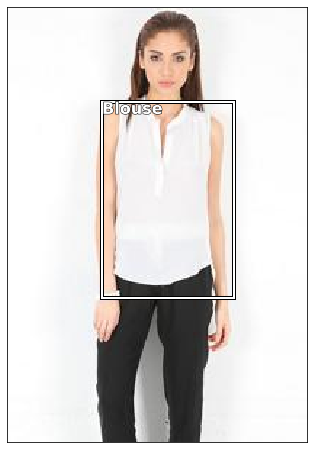

In [13]:
draw_idx(2)

In [14]:
cat = [[p[1] for p in image_ann[o]] for o in file_indexes]
cats = [" ".join(str(p) for p in o) for o in cat]

In [15]:
class_cat_df = pd.DataFrame({"fn": [file_names[o] for o in file_indexes],
                            "cat": [idx2cat[int(o)] for o in cats]}, columns=["fn","cat"])
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/"tmp/fn_cat.csv"
class_cat_df.to_csv(CSV, index=False)
class_cat_df.head()

,fn,cat
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,Blouse
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,Blouse
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,Blouse
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,Blouse
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,Blouse


In [16]:
f_model = resnet34
sz=300
bs=32

In [17]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md_cat = ImageClassifierData.from_csv(PATH, "", CSV, tfms=tfms)

torch.cuda.FloatTensor

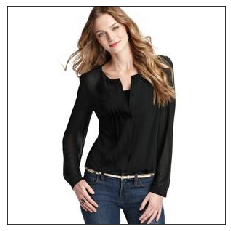

In [18]:
x, y = next(iter(md_cat.val_dl))
show_img(md_cat.val_ds.denorm(to_np(x[0]))[0])
type(x)

In [19]:
bb = [np.concatenate([p[0] for p in image_ann[o]]) for o in file_indexes]
bbs = [" ".join(str(p) for p in o) for o in bb]

In [20]:
regress_bbox_df = pd.DataFrame({'fn': [file_names[o] for o in file_indexes], 'bbox': bbs}, columns=['fn','bbox'])
BB_CSV = PATH/"tmp/fn_bbx"
regress_bbox_df.to_csv(BB_CSV, index=False)
regress_bbox_df.head()

,fn,bbox
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,79 72 273 232
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,59 67 161 155
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65 65 200 156
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,62 51 182 167
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,88 46 262 166


In [21]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, "", BB_CSV, tfms=tfms, continuous=True)

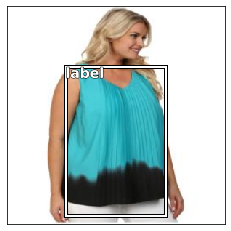

In [22]:
x,y=next(iter(md.aug_dl))
ima = md.val_ds.denorm(to_np(x))[2]
b = bb_hw(to_np(y[2])); b
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], 'label')

In [23]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [24]:
trn_ds_new = ConcatLblDataset(md.trn_ds, md_cat.trn_y)
val_ds_new = ConcatLblDataset(md.val_ds, md_cat.val_y)

In [25]:
md.trn_dl.dataset = trn_ds_new
md.val_dl.dataset = val_ds_new

In [26]:
x,y = next(iter(md.val_dl))

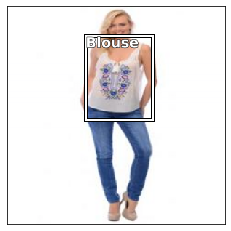

In [27]:
ima = md.val_ds.ds.denorm(to_np(x))[62]
b = bb_hw(to_np(y[0][62]));
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md_cat.classes[y[1][62]])

In [28]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_offsets = np.linspace(anc_offset, 1-anc_offset, anc_grid)
anc_offset, anc_offsets

anc_x = np.repeat(anc_offsets, anc_grid)
anc_x

anc_y = np.tile(anc_offsets, anc_grid)
anc_y

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_ctrs

anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anc_sizes

anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [29]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = image_ann[i]
    im = open_image(IMG_PATH/file_names[i])
    draw_im(im, im_a)

In [30]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    clas = [clas]
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(idx2cat) else idx2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [31]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


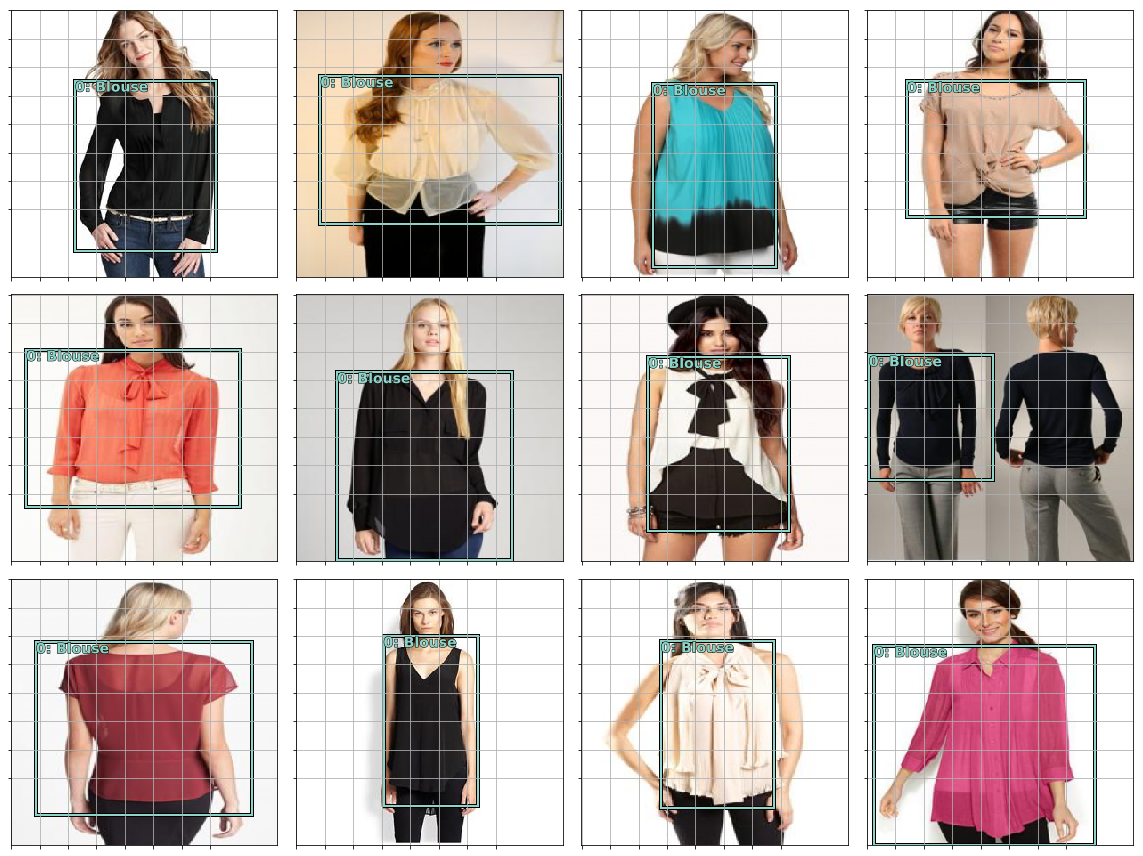

In [32]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

In [33]:
n_clas = len(idx2cat)+1
n_act = k*(4+n_clas)

In [34]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    print(x)
    print()
    return x.view(bs,-1,nf//k)

In [35]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(idx2cat)+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [36]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)


head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
k

1

In [37]:
def intersect(box_a, box_b):
    """ Returns the intersection of two boxes """
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): 
    """ Returns the box size"""
    return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    """ Returns the jaccard distance between two boxes"""
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

def get_y(bbox,clas):
    """ ??? """
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    """ activations to bounding boxes """
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    """ ?? """
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    print(pred[1].shape)
    print(targ[1].shape)
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [39]:
x,y = next(iter(md.val_dl))
#x,y = V(x).cpu(),V(y)
x,y = V(x),V(y)

In [40]:
# learn.model.cuda()
batch = learn.model(x)

In [41]:
type(batch[0].data), type(y[0].data)

(torch.cuda.FloatTensor, torch.cuda.FloatTensor)

In [38]:
learn.crit = ssd_loss
lrf=learn.lr_find(1e-5,100)
learn.sched.plot(0)


  0%|          | 0/3616 [00:00<?, ?it/s]torch.Size([64, 25, 4])
torch.Size([64])


RuntimeError: The size of tensor a (25) must match the size of tensor b (16) at non-singleton dimension 0

In [ ]:
lr = 3e-3
lrs = np.array([lr/100,lr/10,lr])
learn.lr_find(lrs/1000,1.)
learn.sched.plot(1)
learn.fit(lr, 1, cycle_len=1, use_clr=(20,3))
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))
learn.save('0')